## Importing

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import time
import joblib
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

from sklearn.feature_selection import  f_classif, chi2
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder,PowerTransformer, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE


# Read Data 

In [2]:
DATA_PATH = os.path.join(os.getcwd(), '..','Dataset', 'Telco_Cusomer_Churn.csv')

df = pd.read_csv(DATA_PATH)

In [3]:
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')

In [4]:
df.columns

Index(['customerid', 'gender', 'seniorcitizen', 'partner', 'dependents',
       'tenure', 'phoneservice', 'multiplelines', 'internetservice',
       'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport',
       'streamingtv', 'streamingmovies', 'contract', 'paperlessbilling',
       'paymentmethod', 'monthlycharges', 'totalcharges', 'churn'],
      dtype='object')

In [26]:
df

,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
0,Female,No,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,-1.158541,-1.729970,0
1,Male,No,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,-0.239492,0.213698,0
2,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,-0.342665,-1.352157,1
3,Male,No,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),-0.731079,0.192038,0
4,Female,No,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,0.213545,-1.228102,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,Male,No,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,0.671510,0.257414,0
7039,Female,No,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),1.260981,1.634367,0
7040,Female,No,Yes,Yes,11,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,-1.167241,-0.869940,0
7041,Male,Yes,Yes,No,4,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,0.334312,-0.928396,1


## EDA And Visilization

In [5]:
# Colums drops
df.drop(columns=['customerid'], inplace=True, axis=1)
# Not mandatory fetures for churn prediction
#df.drop(columns=['onlinesecurity', 'onlinebackup','deviceprotection','techsupport','streamingtv','streamingmovies', 'paperlessbilling','paymentmethod', 'monthlycharges','totalcharges' ], inplace=True, axis=1)

In [6]:
df.head()

,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [13]:
df['seniorcitizen'] = df['seniorcitizen'].replace({1:'Yes', 0:'No'})
df['totalcharges'] = pd.to_numeric(df['totalcharges'], errors='coerce')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   seniorcitizen     7043 non-null   object 
 2   partner           7043 non-null   object 
 3   dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   phoneservice      7043 non-null   object 
 6   multiplelines     7043 non-null   object 
 7   internetservice   7043 non-null   object 
 8   onlinesecurity    7043 non-null   object 
 9   onlinebackup      7043 non-null   object 
 10  deviceprotection  7043 non-null   object 
 11  techsupport       7043 non-null   object 
 12  streamingtv       7043 non-null   object 
 13  streamingmovies   7043 non-null   object 
 14  contract          7043 non-null   object 
 15  paperlessbilling  7043 non-null   object 
 16  paymentmethod     7043 non-null   object 


In [33]:
df['totalcharges'].isna().sum()
df['totalcharges'].fillna(df['totalcharges'].median(), inplace=True)

C:\Users\20100\AppData\Local\Temp\ipykernel_21604\1191768859.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['totalcharges'].fillna(df['totalcharges'].median(), inplace=True)


In [34]:
df['totalcharges'].isna().sum()

0

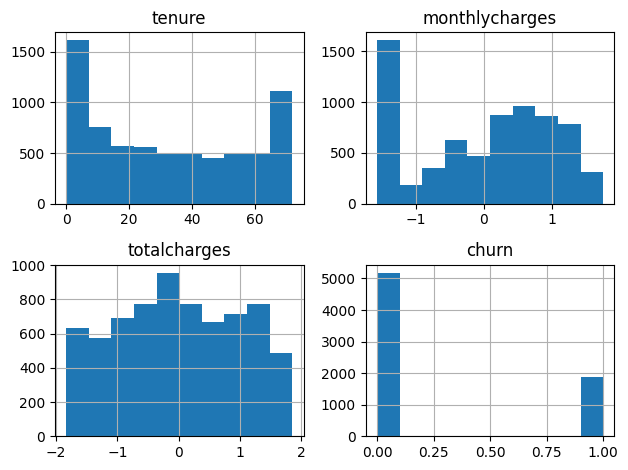

In [36]:
df.hist() 
plt.tight_layout()
plt.show()



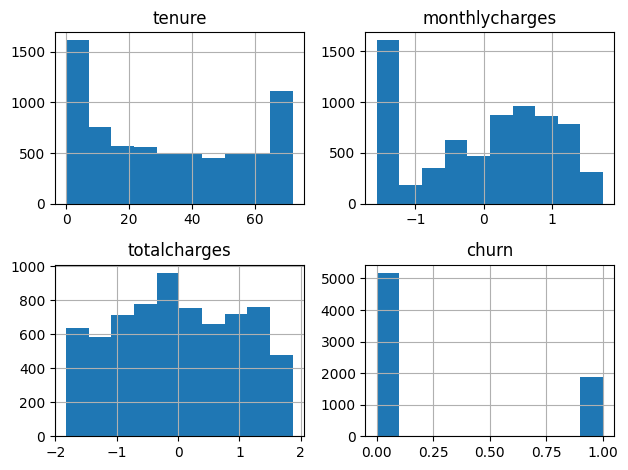

In [37]:
# handle tenure feature distribution
pt = PowerTransformer(method='yeo-johnson')

df['totalcharges'] = pt.fit_transform(df[['totalcharges']])
df.hist() 
plt.tight_layout()
plt.show()


In [18]:
for col in df.columns:
    print(f"{col}: {df[col].unique()}")

gender: ['Female' 'Male']
seniorcitizen: ['No' 'Yes']
partner: ['Yes' 'No']
dependents: ['No' 'Yes']
tenure: [ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0
 39]
phoneservice: ['No' 'Yes']
multiplelines: ['No phone service' 'No' 'Yes']
internetservice: ['DSL' 'Fiber optic' 'No']
onlinesecurity: ['No' 'Yes' 'No internet service']
onlinebackup: ['Yes' 'No' 'No internet service']
deviceprotection: ['No' 'Yes' 'No internet service']
techsupport: ['No' 'Yes' 'No internet service']
streamingtv: ['No' 'Yes' 'No internet service']
streamingmovies: ['No' 'Yes' 'No internet service']
contract: ['Month-to-month' 'One year' 'Two year']
paperlessbilling: ['Yes' 'No']
paymentmethod: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
monthlycharges: [-1.1585412  -0.23949171 -0.34266505 ... -0.

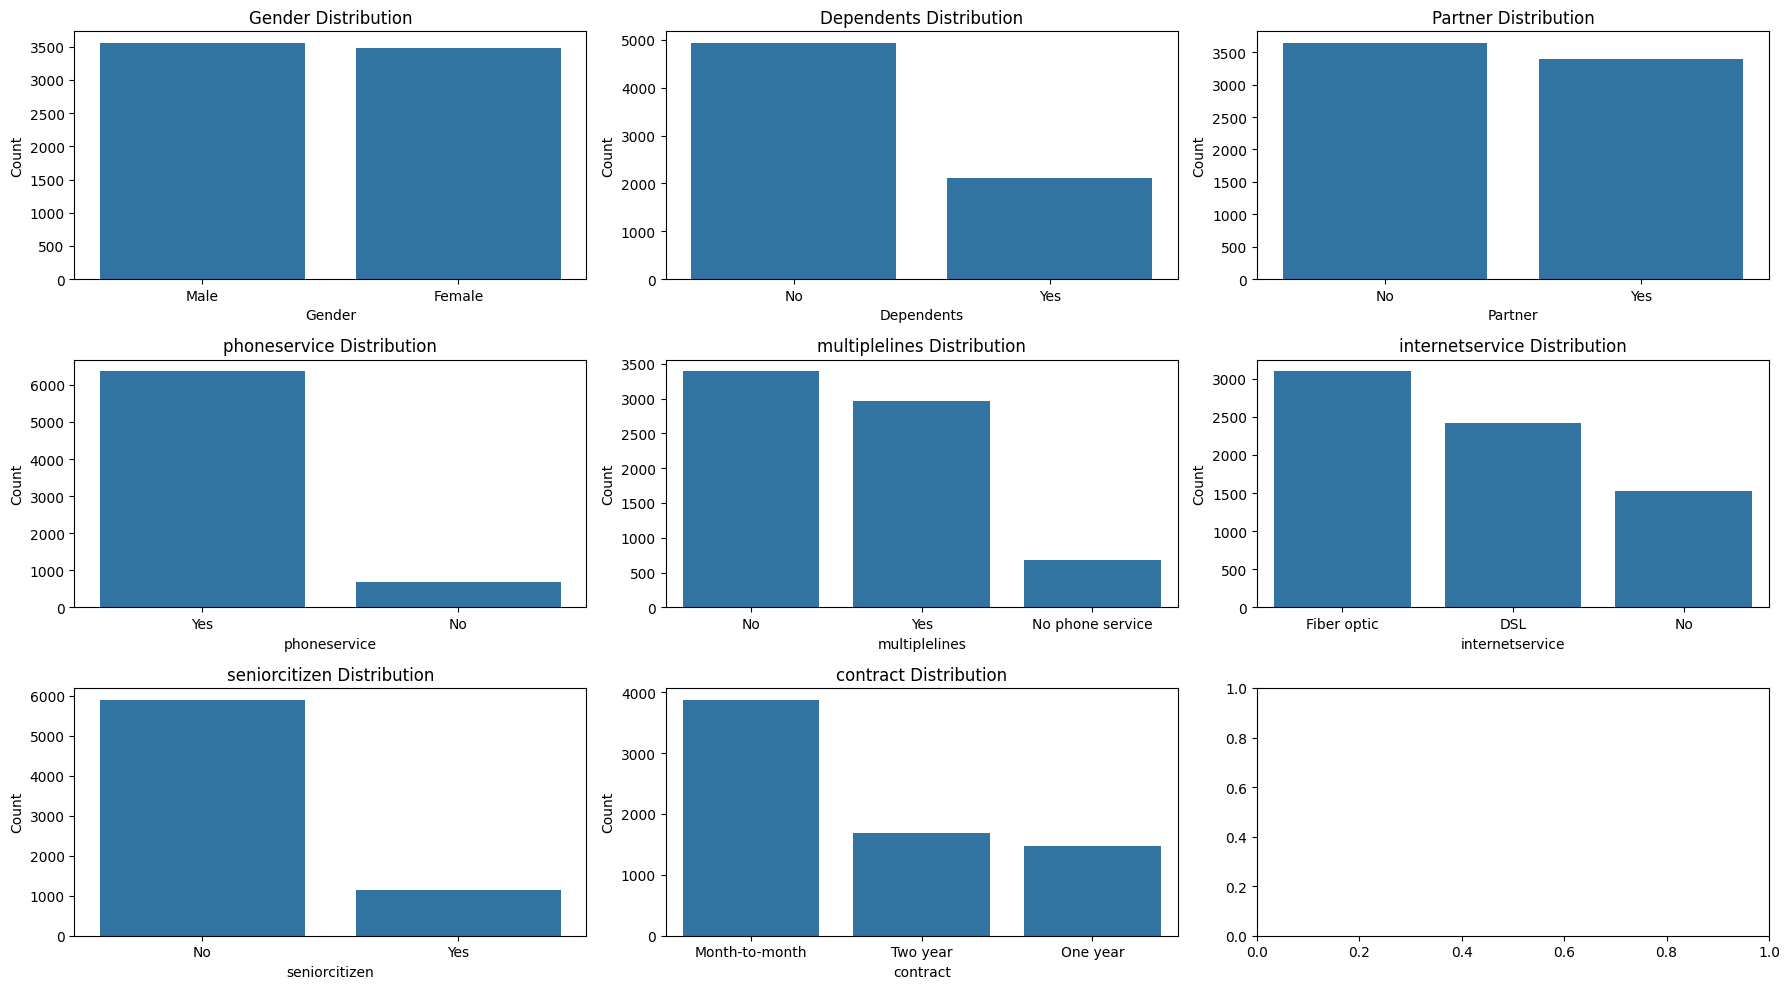

In [19]:

fig, axes = plt.subplots(3, 3, figsize=(18, 10))

# Row 1
# Gender subplot
sns.countplot(data=df, x='gender', order=df['gender'].value_counts().index.tolist(), ax=axes[0,0])
axes[0,0].set_title('Gender Distribution')
axes[0,0].set_xlabel('Gender')
axes[0,0].set_ylabel('Count')

# Dependents subplot
sns.countplot(data=df, x='dependents', order=df['dependents'].value_counts().index.tolist(), ax=axes[0,1])
axes[0,1].set_title('Dependents Distribution')
axes[0,1].set_xlabel('Dependents')
axes[0,1].set_ylabel('Count')

# Partner subplot
sns.countplot(data=df, x='partner', order=df['partner'].value_counts().index.tolist(), ax=axes[0,2])
axes[0,2].set_title('Partner Distribution')
axes[0,2].set_xlabel('Partner')
axes[0,2].set_ylabel('Count')

# phoneservice subplot
sns.countplot(data=df, x='phoneservice', order=df['phoneservice'].value_counts().index.tolist(), ax=axes[1,0])
axes[1,0].set_title('phoneservice Distribution')
axes[1,0].set_xlabel('phoneservice')
axes[1,0].set_ylabel('Count')


sns.countplot(data=df, x='multiplelines', order=df['multiplelines'].value_counts().index.tolist(), ax=axes[1,1])
axes[1,1].set_title('multiplelines Distribution')
axes[1,1].set_xlabel('multiplelines')
axes[1,1].set_ylabel('Count')


sns.countplot(data=df, x='internetservice', order=df['internetservice'].value_counts().index.tolist(), ax=axes[1,2])
axes[1,2].set_title('internetservice Distribution')
axes[1,2].set_xlabel('internetservice')
axes[1,2].set_ylabel('Count')

sns.countplot(data=df, x='seniorcitizen', order=df['seniorcitizen'].value_counts().index.tolist(), ax=axes[2,0])
axes[2,0].set_title('seniorcitizen Distribution')
axes[2,0].set_xlabel('seniorcitizen')
axes[2,0].set_ylabel('Count')

sns.countplot(data=df, x='contract', order=df['contract'].value_counts().index.tolist(), ax=axes[2,1])
axes[2,1].set_title('contract Distribution')
axes[2,1].set_xlabel('contract')
axes[2,1].set_ylabel('Count')


plt.tight_layout()
plt.show()

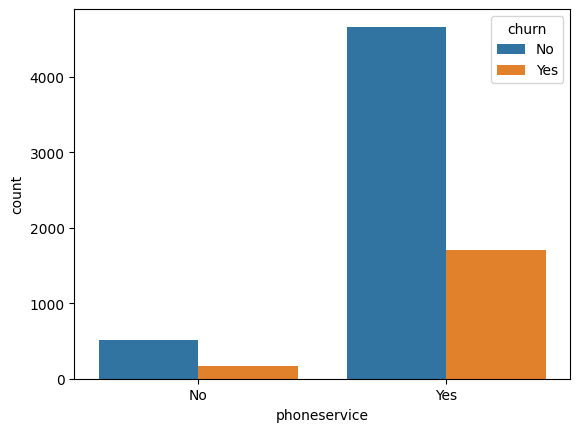

In [20]:
sns.countplot(data=df,x='phoneservice', hue='churn')  ## labels, titles
plt.show()

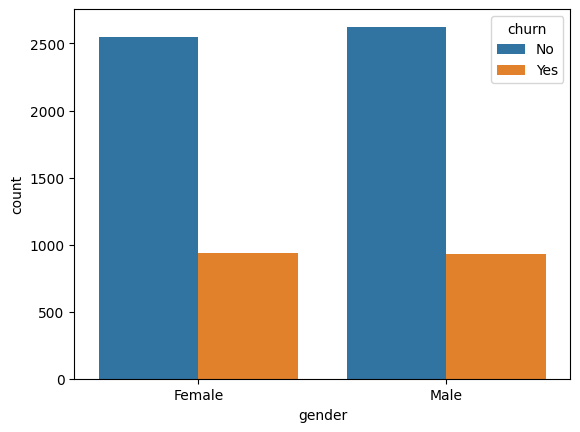

In [62]:
sns.countplot(data=df,x='gender', hue='churn')  ## labels, titles
plt.show()

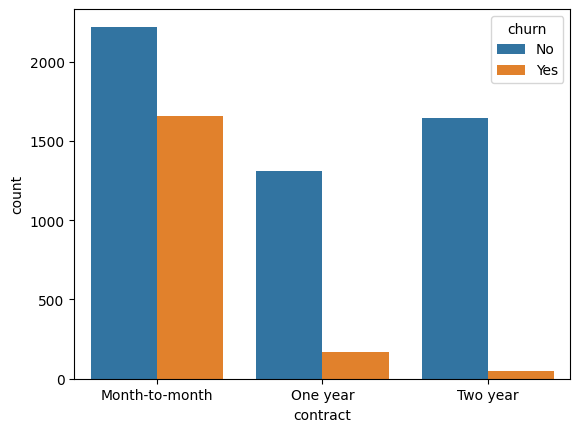

In [63]:
sns.countplot(data=df,x='contract', hue='churn')  ## labels, titles
plt.show()

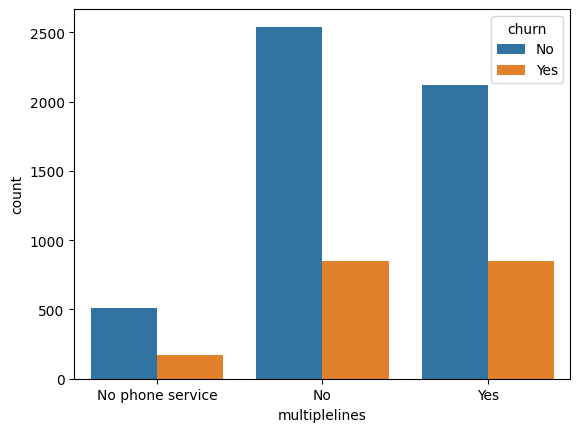

In [64]:
sns.countplot(data=df,x='multiplelines', hue='churn')  ## labels, titles
plt.show()

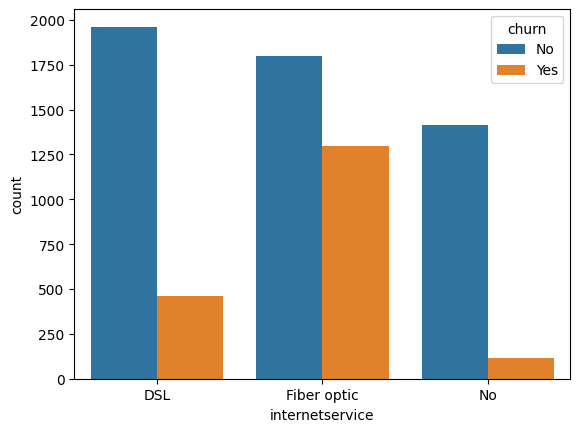

In [65]:

sns.countplot(data=df,x='internetservice', hue='churn')  ## labels, titles
plt.show()


In [38]:
df['churn'].value_counts(normalize=True) # need to handle imbalance dataset

churn
0    0.73463
1    0.26537
Name: proportion, dtype: float64

In [39]:
df['churn'] = df['churn'].replace({'Yes':1, 'No':0})

## Pre-Processing

In [40]:
# Split the data
X = df.drop('churn', axis=1)
y = df['churn']

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Check shapes
print('X_train.shape \t', x_train.shape)
print('y_train.shape \t', y_train.shape)
print('***'*10)
print('X_test.shape \t', x_test.shape)
print('y_test.shape \t', y_test.shape)

X_train.shape 	 (5634, 19)
y_train.shape 	 (5634,)
******************************
X_test.shape 	 (1409, 19)
y_test.shape 	 (1409,)


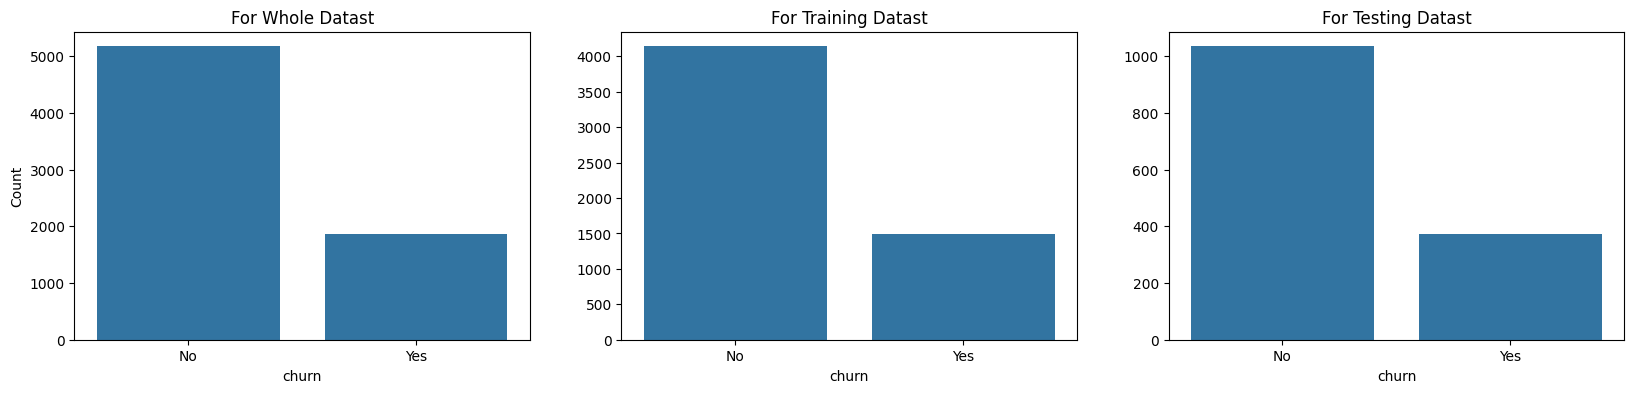

In [41]:
# plottting to check
fig, ax = plt.subplots(1, 3, figsize=(20, 4))

# Whole dataset
plt.sca(ax[0])
sns.countplot(x=y)
plt.title('For Whole Datast')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['No', 'Yes'])

# train
plt.sca(ax[1])
sns.countplot(x=y_train)
plt.title('For Training Datast')
plt.ylabel('')
plt.xticks(ticks=[0, 1], labels=['No', 'Yes'])

# test
plt.sca(ax[2])
sns.countplot(x=y_test)
plt.title('For Testing Datast')
plt.ylabel('')
plt.xticks(ticks=[0, 1], labels=['No', 'Yes'])
plt.show()

#### Feature Selection

In [42]:
for col in df.columns:
    print(f"{col}: {df[col].unique()}")

gender: ['Female' 'Male']
seniorcitizen: ['No' 'Yes']
partner: ['Yes' 'No']
dependents: ['No' 'Yes']
tenure: [ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0
 39]
phoneservice: ['No' 'Yes']
multiplelines: ['No phone service' 'No' 'Yes']
internetservice: ['DSL' 'Fiber optic' 'No']
onlinesecurity: ['No' 'Yes' 'No internet service']
onlinebackup: ['Yes' 'No' 'No internet service']
deviceprotection: ['No' 'Yes' 'No internet service']
techsupport: ['No' 'Yes' 'No internet service']
streamingtv: ['No' 'Yes' 'No internet service']
streamingmovies: ['No' 'Yes' 'No internet service']
contract: ['Month-to-month' 'One year' 'Two year']
paperlessbilling: ['Yes' 'No']
paymentmethod: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
monthlycharges: [-1.1585412  -0.23949171 -0.34266505 ... -0.

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   seniorcitizen     7043 non-null   object 
 2   partner           7043 non-null   object 
 3   dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   phoneservice      7043 non-null   object 
 6   multiplelines     7043 non-null   object 
 7   internetservice   7043 non-null   object 
 8   onlinesecurity    7043 non-null   object 
 9   onlinebackup      7043 non-null   object 
 10  deviceprotection  7043 non-null   object 
 11  techsupport       7043 non-null   object 
 12  streamingtv       7043 non-null   object 
 13  streamingmovies   7043 non-null   object 
 14  contract          7043 non-null   object 
 15  paperlessbilling  7043 non-null   object 
 16  paymentmethod     7043 non-null   object 


In [43]:
numerical_features = ['tenure','monthlycharges', 'totalcharges' ]
categorical_features = ['gender','multiplelines','internetservice','contract', 'onlinesecurity', 'onlinebackup','deviceprotection','techsupport','streamingtv','streamingmovies', 'paymentmethod']
ready_features = list(set(x_train.columns.tolist()) - set(numerical_features) - set(categorical_features))




In [44]:
# Feature Selection for numerical features
_, p_values = f_classif(x_train[numerical_features], y_train)
p_values # less than 0.05 significant feature

[True if p <0.05 else False for p in p_values]

[True, True, True]

In [ ]:
_, p_values = chi2(OrdinalEncoder().fit_transform(x_train[categorical_features]), y_train)
p_values

[True if p < 0.05 else False for p in p_values]
# Gender and streamingtv features seems not significant

[False, True, True, True, True, True, True, True, False, True, True]

In [46]:
_, p_values = chi2(OrdinalEncoder().fit_transform(x_train[ready_features]), y_train)
[True if p <0.05 else False for p in p_values]

# phoneservice seems not significant

[True, True, False, True, True]

In [ ]:
# Try: Drop un significant features and retrain the model

df.drop(columns=['phoneservice','gender','streamingtv'], inplace=True, axis=1)

x_train.drop(columns=['phoneservice','gender','streamingtv'], inplace=True, axis=1)
x_test.drop(columns=['phoneservice','gender','streamingtv'], inplace=True, axis=1)

numerical_features = ['tenure','monthlycharges', 'totalcharges' ]
categorical_features = ['multiplelines','internetservice','contract', 'onlinesecurity', 'onlinebackup','deviceprotection','techsupport','streamingmovies', 'paymentmethod']
ready_features = list(set(x_train.columns.tolist()) - set(numerical_features) - set(categorical_features))



In [50]:
numerical_pipline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])


categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])


ready_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder())
])


# Combine all pipelines using ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_pipline, numerical_features),
    ('cat', categorical_pipeline, categorical_features),
    ('ready', ready_pipeline, ready_features)
])

# Fit and transform the training data
x_train_processed = preprocessor.fit_transform(x_train)
x_test_processed = preprocessor.transform(x_test)


# Save the preprocessor
joblib.dump(preprocessor, os.path.join(os.getcwd(), '..','Models', 'preprocessor.joblib'))



['d:\\work\\Machine_Learning\\MachineLearningAndDeepLearning\\Telcom_Customer_Churn_Class\\notebooks\\..\\Models\\preprocessor.joblib']

#### Handle Unbalaced Data

In [51]:
vals_count = 1 - (np.bincount(y_train) / len(y_train))
vals_count = vals_count / sum(vals_count)

dict_weights = {}
for i in range(2):  # 2 classes (0, 1)
    dict_weights[i] = vals_count[i]

# to model
dict_weights


{0: 0.26535321263755773, 1: 0.7346467873624423}

In [52]:
# 2. Using SMOTE for over sampling
over = SMOTE(k_neighbors=5, sampling_strategy=0.7, random_state=45)
X_train_processed_resampled, y_train_resampled = over.fit_resample(x_train_processed, y_train)

## Models Implementation

### Logistic Regression

In [54]:

lr = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.5, random_state=45, class_weight=dict_weights)
lr.fit(x_train_processed, y_train)



y_pred_train_lr = lr.predict(x_train_processed)
y_pred_test_lr = lr.predict(x_test_processed)



print("Logistic Regression - Training Classification Report")
print(classification_report(y_train, y_pred_train_lr))


socre_train_lr = f1_score(y_train, y_pred_train_lr)
socre_test_lr = f1_score(y_test, y_pred_test_lr)

print("-------------------------------------"*2)
print(f'The f1_score using Logistic model for Training Dataset is {socre_train_lr*100:.3f}')
print(f'The f1_score using Logistic model for Testing Dataset is {socre_test_lr*100:.3f}')



#Extract Model Report
with open(os.path.join(os.getcwd(), '..','reports', 'logistic_regression_model_with_extra_features_report.txt'), 'wb') as f:
    f.write("Logistic Regression - Training Classification Report\n".encode('utf-8'))
    f.write(classification_report(y_train_resampled, y_pred_train_lr).encode('utf-8'))
    f.write("\n\n".encode('utf-8'))
    f.write("--------------------------------------------------------\n".encode('utf-8'))
    f.write(f'The f1_score using Logistic model for Training Dataset is {socre_train_lr*100:.3f}\n'.encode('utf-8'))
    f.write(f'The f1_score using Logistic model for Testing Dataset is {socre_test_lr*100:.3f}\n'.encode('utf-8'))
   


Logistic Regression - Training Classification Report
              precision    recall  f1-score   support

           0       0.91      0.75      0.82      4139
           1       0.53      0.79      0.64      1495

    accuracy                           0.76      5634
   macro avg       0.72      0.77      0.73      5634
weighted avg       0.81      0.76      0.77      5634

--------------------------------------------------------------------------
The f1_score using Logistic model for Training Dataset is 63.806
The f1_score using Logistic model for Testing Dataset is 62.194


ValueError: Found input variables with inconsistent numbers of samples: [7036, 5634]

In [55]:

lr = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.5, random_state=45)
lr.fit(X_train_processed_resampled, y_train_resampled)



y_pred_train_lr = lr.predict(X_train_processed_resampled)
y_pred_test_lr = lr.predict(x_test_processed)



print("Logistic Regression - Training Classification Report")
print(classification_report(y_train_resampled, y_pred_train_lr))


socre_train_lr = f1_score(y_train_resampled, y_pred_train_lr)
socre_test_lr = f1_score(y_test, y_pred_test_lr)

print("-------------------------------------"*2)
print(f'The f1_score using Logistic model for Training Dataset is {socre_train_lr*100:.3f}')
print(f'The f1_score using Logistic model for Testing Dataset is {socre_test_lr*100:.3f}')



# Extract Model Report
with open(os.path.join(os.getcwd(), '..','reports', 'logistic_regression_model_with_extra_features_report.txt'), 'wb') as f:
    f.write("Logistic Regression - Training Classification Report\n".encode('utf-8'))
    f.write(classification_report(y_train_resampled, y_pred_train_lr).encode('utf-8'))
    f.write("\n\n".encode('utf-8'))
    f.write("--------------------------------------------------------\n".encode('utf-8'))
    f.write(f'The f1_score using Logistic model for Training Dataset is {socre_train_lr*100:.3f}\n'.encode('utf-8'))
    f.write(f'The f1_score using Logistic model for Testing Dataset is {socre_test_lr*100:.3f}\n'.encode('utf-8'))
   


Logistic Regression - Training Classification Report
              precision    recall  f1-score   support

           0       0.81      0.82      0.82      4139
           1       0.74      0.73      0.74      2897

    accuracy                           0.79      7036
   macro avg       0.78      0.78      0.78      7036
weighted avg       0.79      0.79      0.79      7036

--------------------------------------------------------------------------
The f1_score using Logistic model for Training Dataset is 73.818
The f1_score using Logistic model for Testing Dataset is 63.723


<Axes: >

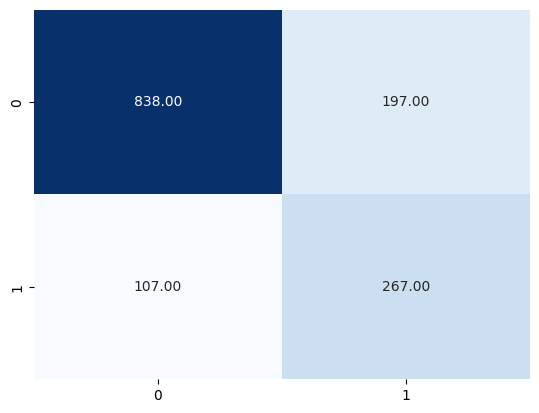

In [56]:
sns.heatmap(confusion_matrix(y_true=y_test, y_pred=y_pred_test_lr), cmap='Blues', cbar=False, annot=True, fmt='.2f')

In [81]:
joblib.dump(lr, os.path.join(os.getcwd(), '..','Models', 'logistic_regression_model.joblib'))

['d:\\work\\Machine_Learning\\MachineLearningAndDeepLearning\\Telcom_Customer_Churn_Class\\notebooks\\..\\Models\\logistic_regression_model.joblib']

----------

### SVM

In [62]:
svm = SVC(C=1.5, random_state=45)
svm.fit(X_train_processed_resampled, y_train_resampled)

y_pred_train_svm = svm.predict(X_train_processed_resampled)
y_pred_test_svm = svm.predict(x_test_processed)

# Model Result Report 
print("SVM - Training Classification Report")
print(classification_report(y_train_resampled, y_pred_train_svm))

print("SVM - Testing Classification Report")
print(classification_report(y_test, y_pred_test_svm))


score_train_svm = f1_score(y_train_resampled, y_pred_train_svm)
score_test_svm = f1_score(y_test, y_pred_test_svm)
print("-------------------------------------"*2)
print(f'The f1_score using Logistic model for Training Dataset is {score_train_svm*100:.3f}')
print(f'The f1_score using Logistic model for Testing Dataset is {score_test_svm*100:.3f}')


# Extract Model Report
with open(os.path.join(os.getcwd(), '..','reports', 'SVM_model_with_extra_features_report.txt'), 'wb') as f:
    f.write("SVM - Training Classification Report\n".encode('utf-8'))
    f.write(classification_report(y_train_resampled, y_pred_train_svm).encode('utf-8'))
    f.write("\n\n".encode('utf-8'))
    f.write("SVM - Testing Classification Report\n".encode('utf-8'))
    f.write(classification_report(y_test, y_pred_test_svm).encode('utf-8'))
    f.write("\n\n".encode('utf-8'))
    f.write("--------------------------------------------------------\n".encode('utf-8'))
    f.write(f'The f1_score using SVM model for Training Dataset is {score_train_svm*100:.3f}\n'.encode('utf-8'))
    f.write(f'The f1_score using SVM model for Testing Dataset is {score_test_svm*100:.3f}\n'.encode('utf-8'))
   



SVM - Training Classification Report
              precision    recall  f1-score   support

           0       0.85      0.84      0.85      4139
           1       0.78      0.79      0.79      2897

    accuracy                           0.82      7036
   macro avg       0.81      0.82      0.82      7036
weighted avg       0.82      0.82      0.82      7036

SVM - Testing Classification Report
              precision    recall  f1-score   support

           0       0.88      0.81      0.84      1035
           1       0.56      0.69      0.62       374

    accuracy                           0.78      1409
   macro avg       0.72      0.75      0.73      1409
weighted avg       0.79      0.78      0.78      1409

--------------------------------------------------------------------------
The f1_score using Logistic model for Training Dataset is 78.526
The f1_score using Logistic model for Testing Dataset is 62.094


<Axes: >

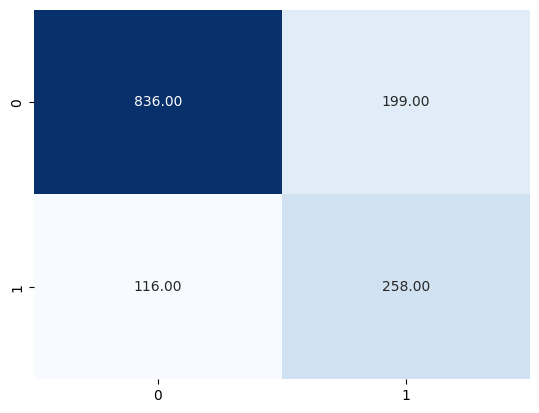

In [63]:
sns.heatmap(confusion_matrix(y_true=y_test, y_pred=y_pred_test_svm), cmap='Blues', cbar=False, annot=True, fmt='.2f')

In [84]:
joblib.dump(svm, os.path.join(os.getcwd(), '..','Models', 'SVM_model.joblib'))

['d:\\work\\Machine_Learning\\MachineLearningAndDeepLearning\\Telcom_Customer_Churn_Class\\notebooks\\..\\Models\\SVM_model.joblib']

### XGBoost

In [68]:
xgboost = XGBClassifier(eval_metric='logloss', random_state=45, learning_rate=0.05, n_estimators=150, max_depth=5)
xgboost.fit(X_train_processed_resampled, y_train_resampled)

y_pred_train_xgb = xgboost.predict(X_train_processed_resampled)
y_pred_test_xgb = xgboost.predict(x_test_processed)

print("XGBoost - Training Classification Report")
print(classification_report(y_train_resampled, y_pred_train_xgb))




score_train_xgb= f1_score(y_train_resampled, y_pred_train_xgb)
score_test_xgb = f1_score(y_test, y_pred_test_xgb)
print("-------------------------------------"*2)
print(f'The f1_score using Logistic model for Training Dataset is {score_train_xgb*100:.3f}')
print(f'The f1_score using Logistic model for Testing Dataset is {score_test_xgb*100:.3f}')


# Extract Model Report
with open(os.path.join(os.getcwd(), '..','reports', 'Xgboost_model_with_extra_features_report.txt'), 'wb') as f:
    f.write("Xgboost - Training Classification Report\n".encode('utf-8'))
    f.write(classification_report(y_train_resampled, y_pred_train_xgb).encode('utf-8'))
    f.write("\n\n".encode('utf-8'))
    f.write("Xgboost - Testing Classification Report\n".encode('utf-8'))
    f.write(classification_report(y_test, y_pred_test_xgb).encode('utf-8'))
    f.write("\n\n".encode('utf-8'))
    f.write("--------------------------------------------------------\n".encode('utf-8'))
    f.write(f'The f1_score using Xgboost model for Training Dataset is {score_train_xgb*100:.3f}\n'.encode('utf-8'))
    f.write(f'The f1_score using Xgboost model for Testing Dataset is {score_test_xgb*100:.3f}\n'.encode('utf-8'))
   


XGBoost - Training Classification Report
              precision    recall  f1-score   support

           0       0.88      0.87      0.87      4139
           1       0.82      0.83      0.82      2897

    accuracy                           0.85      7036
   macro avg       0.85      0.85      0.85      7036
weighted avg       0.85      0.85      0.85      7036

--------------------------------------------------------------------------
The f1_score using Logistic model for Training Dataset is 82.264
The f1_score using Logistic model for Testing Dataset is 61.735


<Axes: >

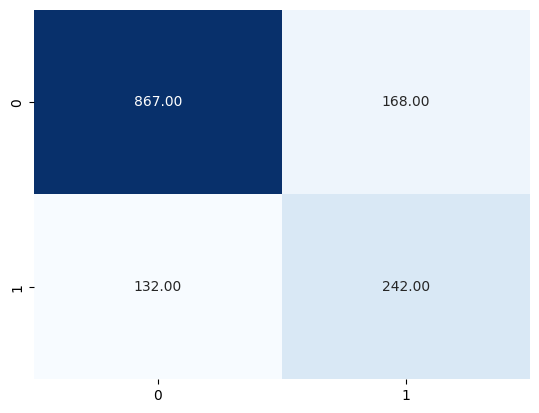

In [69]:
sns.heatmap(confusion_matrix(y_true=y_test, y_pred=y_pred_test_xgb), cmap='Blues', cbar=False, annot=True, fmt='.2f')

In [88]:
# Model saving
joblib.dump(xgboost, os.path.join(os.getcwd(), '..','Models', 'xgboost_model.joblib'))

['d:\\work\\Machine_Learning\\MachineLearningAndDeepLearning\\Telcom_Customer_Churn_Class\\notebooks\\..\\Models\\xgboost_model.joblib']

### Random Forest

In [71]:
rf = RandomForestClassifier(n_estimators=100, max_depth=9, random_state=45)
rf.fit(X_train_processed_resampled, y_train_resampled)

y_pred_train_rf = rf.predict(X_train_processed_resampled)
y_pred_test_rf = rf.predict(x_test_processed)

print("Random Forest - Training Classification Report")
print(classification_report(y_train_resampled, y_pred_train_rf))

score_train_rf= f1_score(y_train_resampled, y_pred_train_rf)
score_test_rf = f1_score(y_test, y_pred_test_rf)
print("-------------------------------------"*2)
print(f'The f1_score using Random Forest model for Training Dataset is {score_train_rf*100:.3f}')
print(f'The f1_score using Random Forest model for Testing Dataset is {score_test_rf*100:.3f}')


# Extract Model Report
with open(os.path.join(os.getcwd(), '..','reports', 'random_forest_model_with_extra_features_report.txt'), 'wb') as f:
    f.write("Random Forest - Training Classification Report\n".encode('utf-8'))
    f.write(classification_report(y_train_resampled, y_pred_train_rf).encode('utf-8'))
    f.write("\n\n".encode('utf-8'))
    f.write("Random Forest - Testing Classification Report\n".encode('utf-8'))
    f.write(classification_report(y_test, y_pred_test_rf).encode('utf-8'))
    f.write("\n\n".encode('utf-8'))
    f.write("--------------------------------------------------------\n".encode('utf-8'))
    f.write(f'The f1_score using Random Forest model for Training Dataset is {score_train_rf*100:.3f}\n'.encode('utf-8'))
    f.write(f'The f1_score using Random Forest model for Testing Dataset is {score_test_rf*100:.3f}\n'.encode('utf-8'))



Random Forest - Training Classification Report
              precision    recall  f1-score   support

           0       0.89      0.86      0.88      4139
           1       0.81      0.86      0.83      2897

    accuracy                           0.86      7036
   macro avg       0.85      0.86      0.85      7036
weighted avg       0.86      0.86      0.86      7036

--------------------------------------------------------------------------
The f1_score using Random Forest model for Training Dataset is 83.079
The f1_score using Random Forest model for Testing Dataset is 60.539


<Axes: >

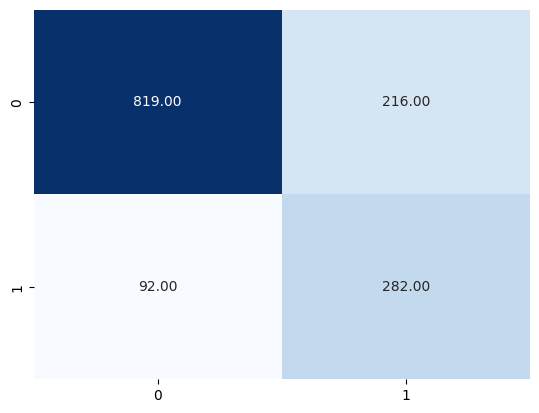

In [100]:
sns.heatmap(confusion_matrix(y_true=y_test, y_pred=y_pred_test_rf), cmap='Blues', cbar=False, annot=True, fmt='.2f')

In [101]:
joblib.dump(rf, os.path.join(os.getcwd(), '..','Models', 'random_forest_model.joblib'))

['d:\\work\\Machine_Learning\\MachineLearningAndDeepLearning\\Telcom_Customer_Churn_Class\\notebooks\\..\\Models\\random_forest_model.joblib']

------------------------